# Plant Leaf Disease Detection

## ADS - 599 Capstone Project
### Team 2

*   Kaustav Ghosh Dastiar
*   Muris Saab
*   Nishok Narayanan





In [60]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D


from keras.preprocessing import image
from keras.preprocessing import image
from keras.models import Sequential
# from keras.layers.core import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.models import Sequential
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix,classification_report
from PIL import Image
import cv2
import random
import tensorflow as tf


import warnings
warnings.filterwarnings("ignore")

# Set default plot style
plt.style.use('ggplot')


In [8]:
# Define the dataset paths (update as necessary)
train_dir = '/Users/muriss/ads599-module7/train' #'/kaggle/input/leaf-disease-detection-dataset/dataset/train'
test_dir = '/Users/muriss/ads599-module7/test' #'/kaggle/input/leaf-disease-detection-dataset/dataset/test'


# Function to load data from directories and create DataFrames
def load_data(directory):
    filepaths, labels = [], []
    class_list = sorted(os.listdir(directory))
    for klass in class_list:
        classpath = os.path.join(directory, klass)

        # Skip files that are not directories
        if not os.path.isdir(classpath):
            continue
        
        parts = klass.split('__')
        label = parts[1] if len(parts) > 1 else 'Unknown'
        
        file_list = os.listdir(classpath)
        for file in file_list:
            filepaths.append(os.path.join(classpath, file))
            labels.append(label)

    return pd.DataFrame({'filepaths': filepaths, 'labels': labels})

# Load training and testing datasets
train_df = load_data(train_dir) if os.path.exists(train_dir) else pd.DataFrame()
test_df = load_data(test_dir) if os.path.exists(test_dir) else pd.DataFrame()

# Display basic info about the datasets
print(f"Training Data: {train_df.shape[0]} samples, {train_df['labels'].nunique()} classes")
print(f"Testing Data: {test_df.shape[0]} samples, {test_df['labels'].nunique()} classes")

Training Data: 70295 samples, 21 classes
Testing Data: 17572 samples, 21 classes


In [9]:
# get the number of classes and the images count for each class in train_df
classes=sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)
groups=train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
countlist=[]
classlist=[]
for label in sorted(list(train_df['labels'].unique())):
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

# get the classes with the minimum and maximum number of train images
max_value=np.max(countlist)
max_index=countlist.index(max_value)
max_class=classlist[max_index]
min_value=np.min(countlist)
min_index=countlist.index(min_value)
min_class=classlist[min_index]
print(max_class, ' has the most images= ',max_value, ' ', min_class, ' has the least images= ', min_value)
# lets get the average height and width of a sample of the train images
ht=0
wt=0
# select 100 random samples of train_df
train_df_sample=train_df.sample(n=100, random_state=123,axis=0)
for i in range (len(train_df_sample)):
    fpath=train_df_sample['filepaths'].iloc[i]
    img=plt.imread(fpath)
    shape=img.shape
    ht += shape[0]
    wt += shape[1]
print('average height= ', ht//100, ' average width= ', wt//100, 'aspect ratio= ', ht/wt)

The number of classes in the dataset is:  21
            CLASS               IMAGE COUNT 
         _Apple_scab               2016     
       _Bacterial_spot             5453     
          _Black_rot               3875     
      _Cedar_apple_rust            1760     
_Cercospora_leaf_spot Gray_leaf_spot     1642     
        _Common_rust_              1907     
        _Early_blight              3859     
    _Esca_(Black_Measles)          1920     
_Haunglongbing_(Citrus_greening)     2010     
         _Late_blight              3790     
          _Leaf_Mold               1882     
_Leaf_blight_(Isariopsis_Leaf_Spot)     1722     
         _Leaf_scorch              1774     
    _Northern_Leaf_Blight          1908     
       _Powdery_mildew             3419     
     _Septoria_leaf_spot           1745     
_Spider_mites Two-spotted_spider_mite     1741     
         _Target_Spot              1827     
_Tomato_Yellow_Leaf_Curl_Virus     1961     
     _Tomato_mosaic_virus          

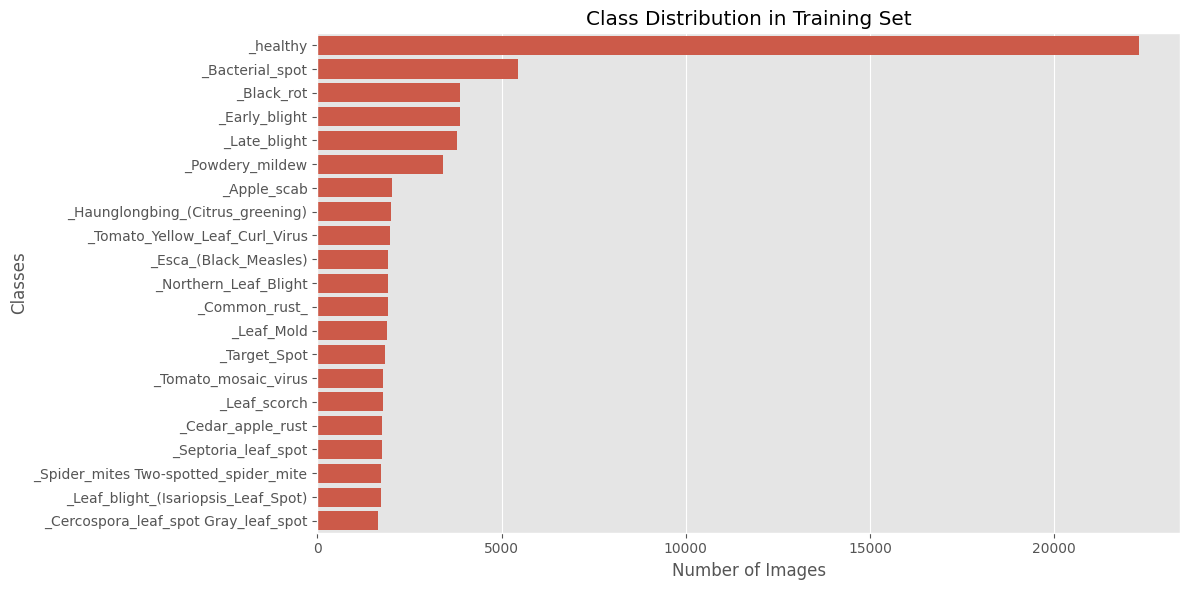

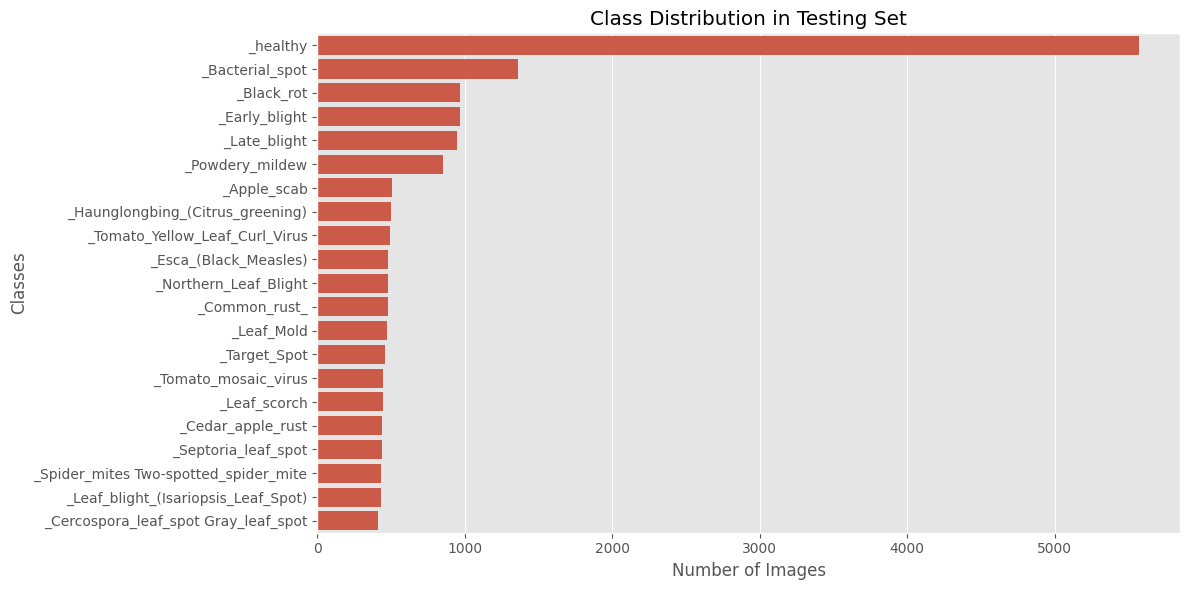

In [10]:

# Visualize class distribution in training set
if not train_df.empty:
    plt.figure(figsize=(12, 6))
    sns.countplot(y=train_df['labels'], order=train_df['labels'].value_counts().index)
    plt.title('Class Distribution in Training Set')
    plt.xlabel('Number of Images')
    plt.ylabel('Classes')
    plt.tight_layout()
    plt.show()

# Visualize class distribution in testing set
if not test_df.empty:
    plt.figure(figsize=(12, 6))
    sns.countplot(y=test_df['labels'], order=test_df['labels'].value_counts().index)
    plt.title('Class Distribution in Testing Set')
    plt.xlabel('Number of Images')
    plt.ylabel('Classes')
    plt.tight_layout()
    plt.show()


In [11]:
train_gen = ImageDataGenerator(rescale=None,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_gen = ImageDataGenerator(rescale=None,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

training_set=train_gen.flow_from_directory(train_dir,
                                               target_size=(128,128),
                                               batch_size=32,
                                               class_mode='categorical')

test_set=test_gen.flow_from_directory(test_dir,
                                               target_size=(128,128),
                                               batch_size=32,
                                               class_mode='categorical')

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


Images for Training......................


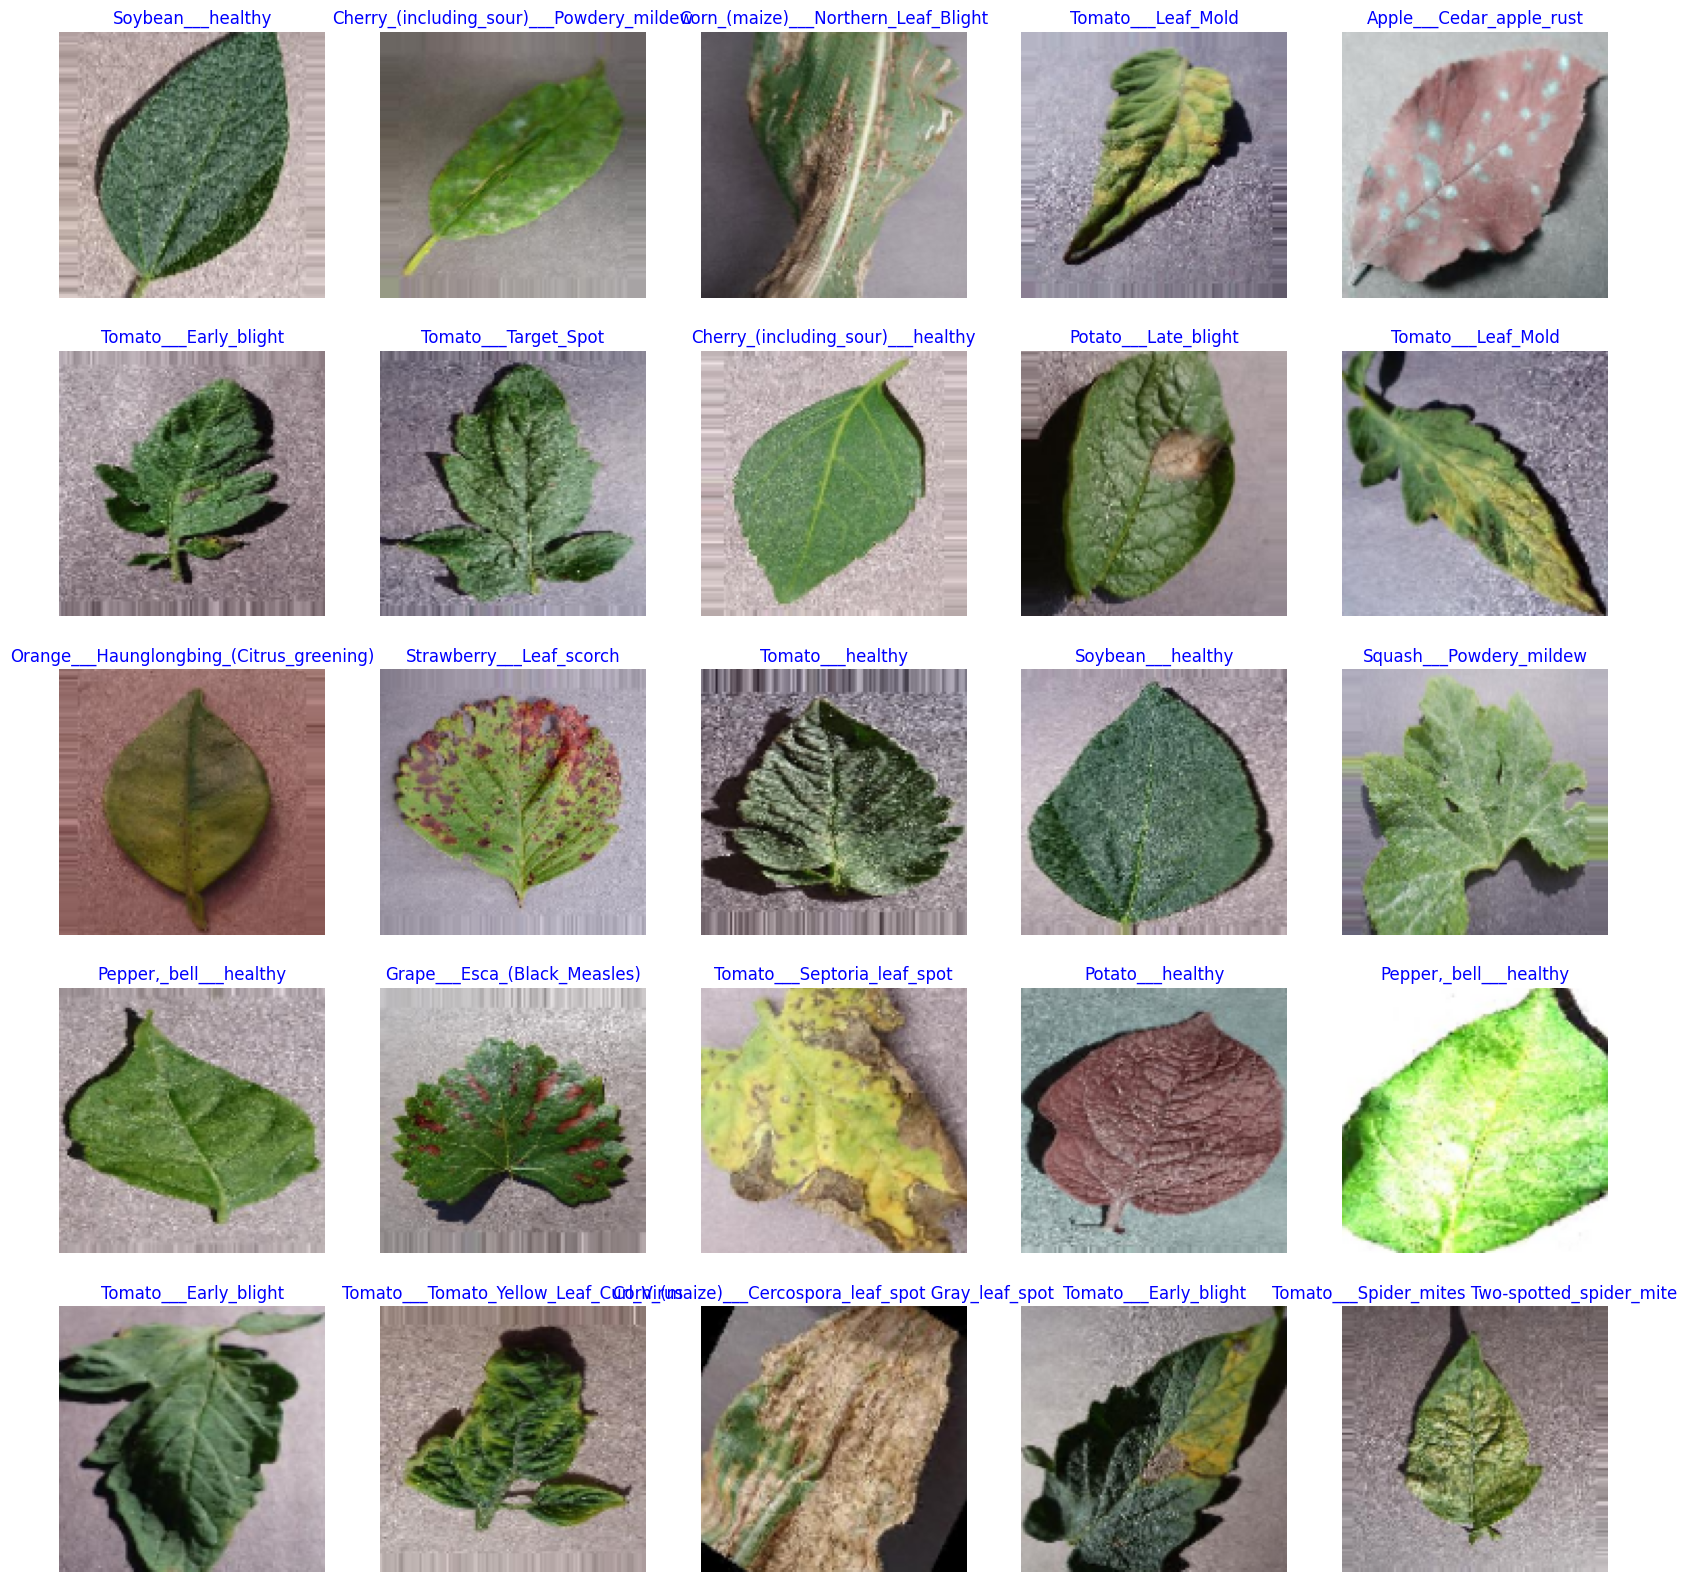

Images for Testing.......................


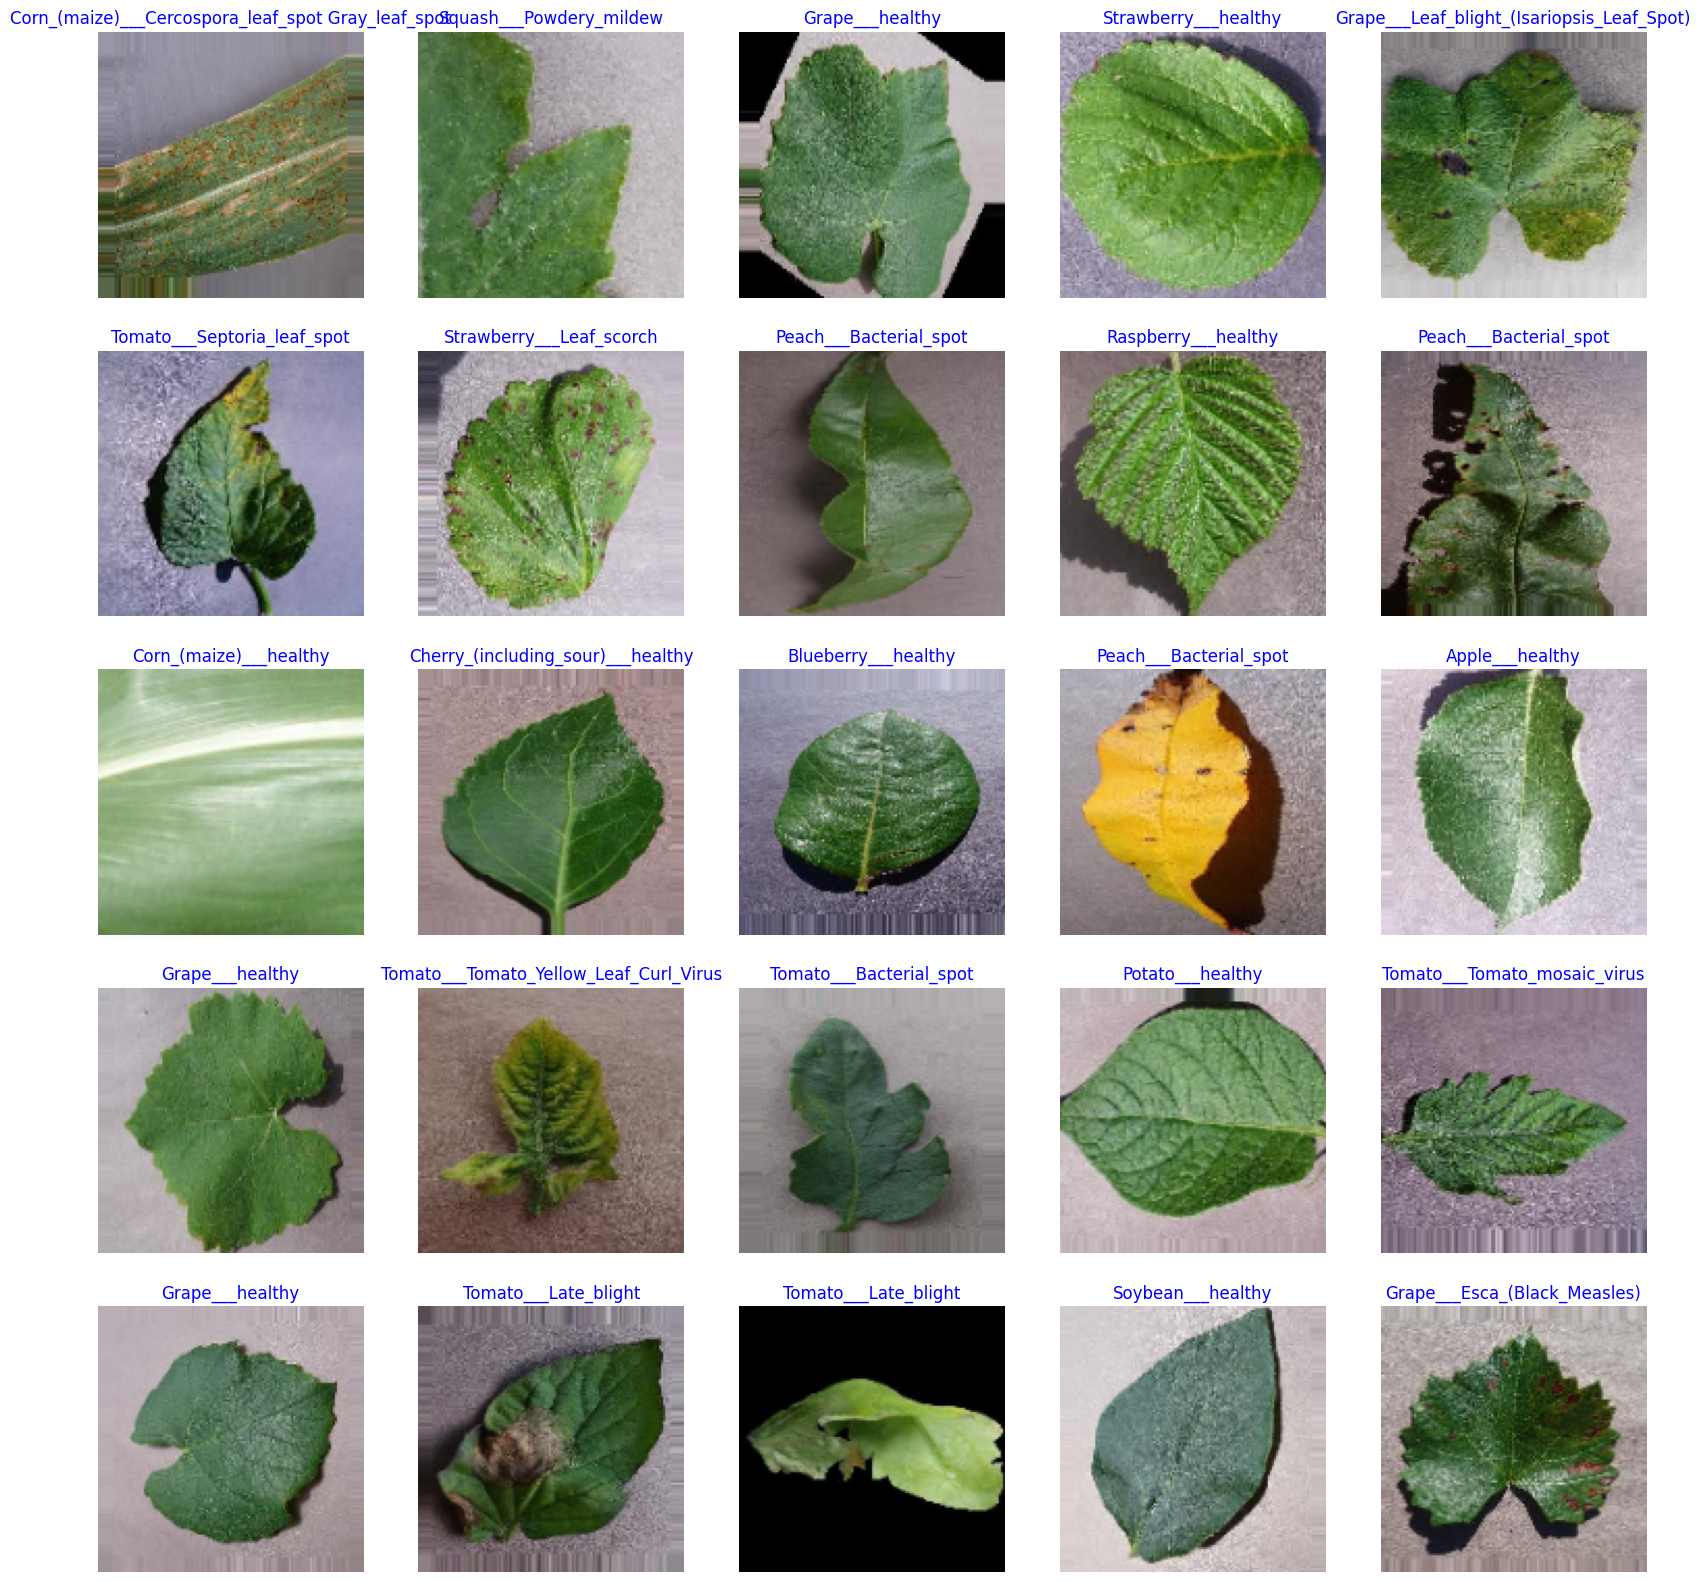

In [12]:
def show_image_samples(gen):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()
    
print("Images for Training......................")
show_image_samples(training_set )
print("Images for Testing.......................")
show_image_samples(test_set )

In [20]:
def analyze_image_dimensions(image_dir):
    """
    Analyze image dimensions and aspect ratios in the given directory.

    Parameters:
        image_dir (str): Path to the directory containing image files.

    Returns:
        dimensions (list of tuple): List of (width, height) for each image.
        aspect_ratios (list of float): List of aspect ratios (width/height) for each image.
    """
    dimensions = []
    aspect_ratios = []
    
    for image_name in os.listdir(image_dir):
        image_path = os.path.join(image_dir, image_name)
        
        # Check if the path is a file and ends with a common image extension
        if os.path.isfile(image_path) and image_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            try:
                image = Image.open(image_path)
                width, height = image.size
                dimensions.append((width, height))
                aspect_ratios.append(width / height)
            except Exception as e:
                print(f"Error processing file {image_name}: {e}")
    
    return dimensions, aspect_ratios

# Example usage
train_dimensions, train_aspect_ratios = analyze_image_dimensions(train_dir)
test_dimensions, test_aspect_ratios = analyze_image_dimensions(test_dir)


Processed 100 images from /Users/muriss/ads599-module7/train
Processed 100 images from /Users/muriss/ads599-module7/test


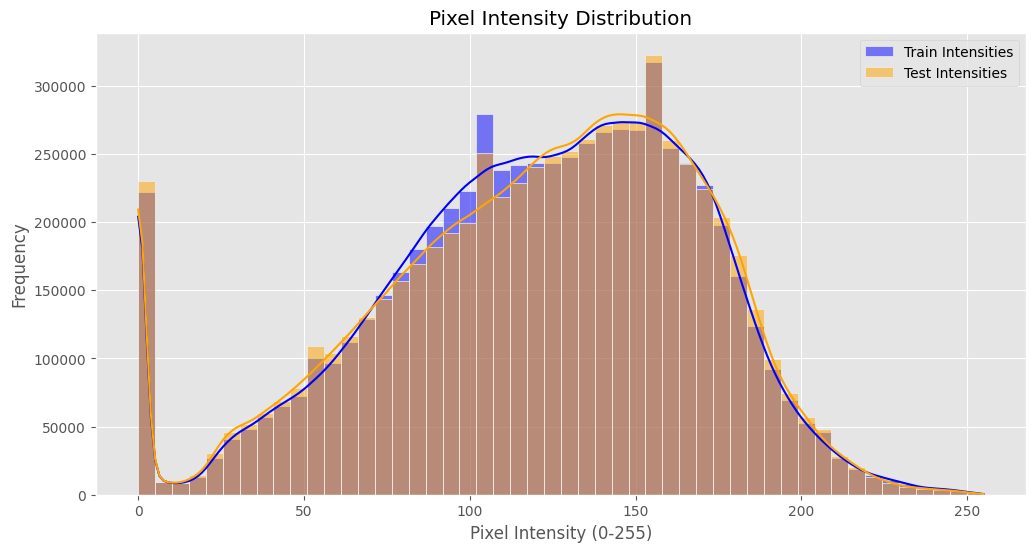

In [22]:
def pixel_intensity_distribution(base_dir, max_images=500):
    """
    Analyze pixel intensity distributions in grayscale images, limited to a maximum number of images.

    Parameters:
        base_dir (str): Path to the base directory containing subdirectories with images.
        max_images (int): Maximum number of images to process.

    Returns:
        intensities (list): List of pixel intensity values.
    """
    intensities = []
    image_count = 0  # Counter for processed images
    max_images = 100
    # Traverse all subdirectories
    for subdir in os.listdir(base_dir):
        subdir_path = os.path.join(base_dir, subdir)
        if os.path.isdir(subdir_path):  # Ensure it's a directory
            for image_name in os.listdir(subdir_path):
                if image_count >= max_images:  # Stop if we've reached the limit
                    break
                image_path = os.path.join(subdir_path, image_name)
                # Ensure the file is a valid image
                if image_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                    try:
                        # Use PIL to open and convert the image to grayscale
                        with Image.open(image_path).convert("L") as img:  # "L" converts to grayscale
                            image_array = np.array(img)  # Convert to NumPy array
                            intensities.extend(image_array.flatten())  # Flatten and extend list
                            image_count += 1  # Increment image count
                    except Exception as e:
                        print(f"Warning: Unable to process {image_path}. Error: {e}")
    print(f"Processed {image_count} images from {base_dir}")
    return intensities

# # Paths to the train and test image directories
# train_images_dir = "../dataset/train"
# test_images_dir = "../dataset/test"

# Analyze train and test image intensities, limited to 500 images
train_intensities = pixel_intensity_distribution(train_dir, max_images=500)
test_intensities = pixel_intensity_distribution(test_dir, max_images=500)

# Plot pixel intensity distributions
if train_intensities and test_intensities:  # Ensure data is not empty
    plt.figure(figsize=(12, 6))
    sns.histplot(train_intensities, kde=True, label='Train Intensities', color='blue', bins=50)
    sns.histplot(test_intensities, kde=True, label='Test Intensities', color='orange', bins=50)
    plt.title("Pixel Intensity Distribution")
    plt.xlabel("Pixel Intensity (0-255)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
else:
    print("Warning: No data to plot. Check the image directories.")

Processed 100 images from /Users/muriss/ads599-module7/train.
Processed 100 images from /Users/muriss/ads599-module7/test.


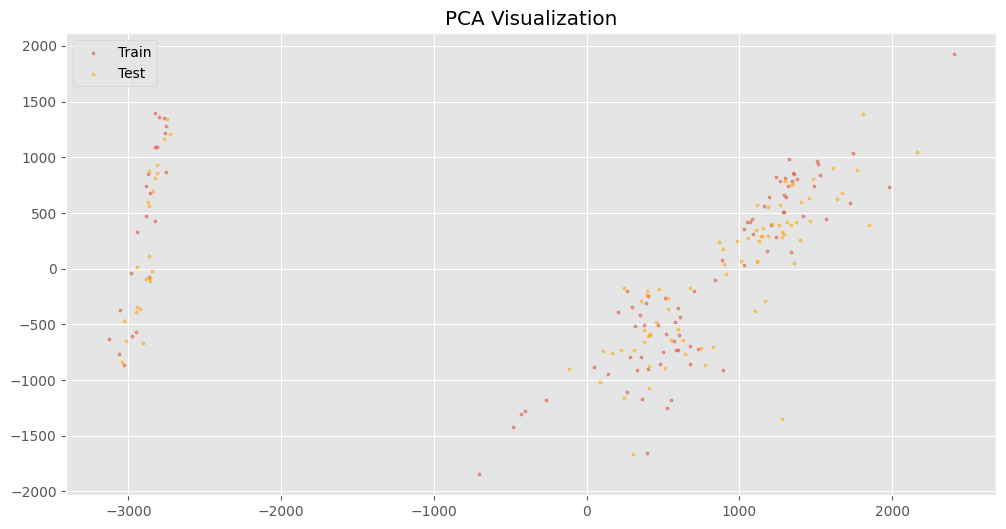

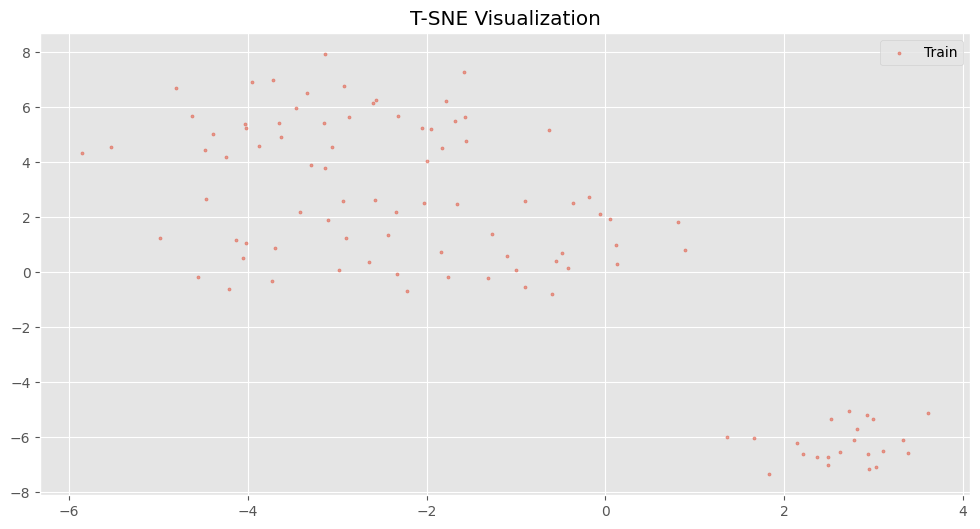

In [23]:
def extract_features(base_dir, limit=500):
    """
    Extract features from images in a directory, limited to a specific number of images.

    Parameters:
        base_dir (str): Path to the image directory.
        max_images (int): Maximum number of images to process.

    Returns:
        np.array: Flattened image features.
    """
    features = []
    image_count = 0
    max_images = 100

    # Traverse all subdirectories
    for subdir in os.listdir(base_dir):
        subdir_path = os.path.join(base_dir, subdir)
        if os.path.isdir(subdir_path):  # Ensure it's a directory
            for image_name in os.listdir(subdir_path):
                if image_count >= max_images:  # Stop if we've reached the limit
                    break
                image_path = os.path.join(subdir_path, image_name)
                # Ensure the file is a valid image
                if image_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                    try:
                        # Load the image in grayscale
                        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                        if image is not None:
                            # Resize to 64x64 and flatten
                            image_resized = cv2.resize(image, (64, 64)).flatten()
                            features.append(image_resized)
                            image_count += 1  # Increment the count
                        else:
                            print(f"Warning: Unable to read {image_path}. Skipping.")
                    except Exception as e:
                        print(f"Error processing {image_path}: {e}")
    print(f"Processed {image_count} images from {base_dir}.")
    return np.array(features)

# Extract features
train_features = extract_features(train_dir)
test_features = extract_features(test_dir)

# Apply PCA
pca = PCA(n_components=2)
train_pca = pca.fit_transform(train_features)
test_pca = pca.transform(test_features)

plt.figure(figsize=(12, 6))
plt.scatter(train_pca[:, 0], train_pca[:, 1], label='Train', alpha=0.5, s=5)
plt.scatter(test_pca[:, 0], test_pca[:, 1], label='Test', alpha=0.5, s=5, color='orange')
plt.title('PCA Visualization')
plt.legend()
plt.show()

# Apply T-SNE
tsne = TSNE(n_components=2, random_state=42)
train_tsne = tsne.fit_transform(train_features)

plt.figure(figsize=(12, 6))
plt.scatter(train_tsne[:, 0], train_tsne[:, 1], label='Train', alpha=0.5, s=5)
plt.title('T-SNE Visualization')
plt.legend()
plt.show()

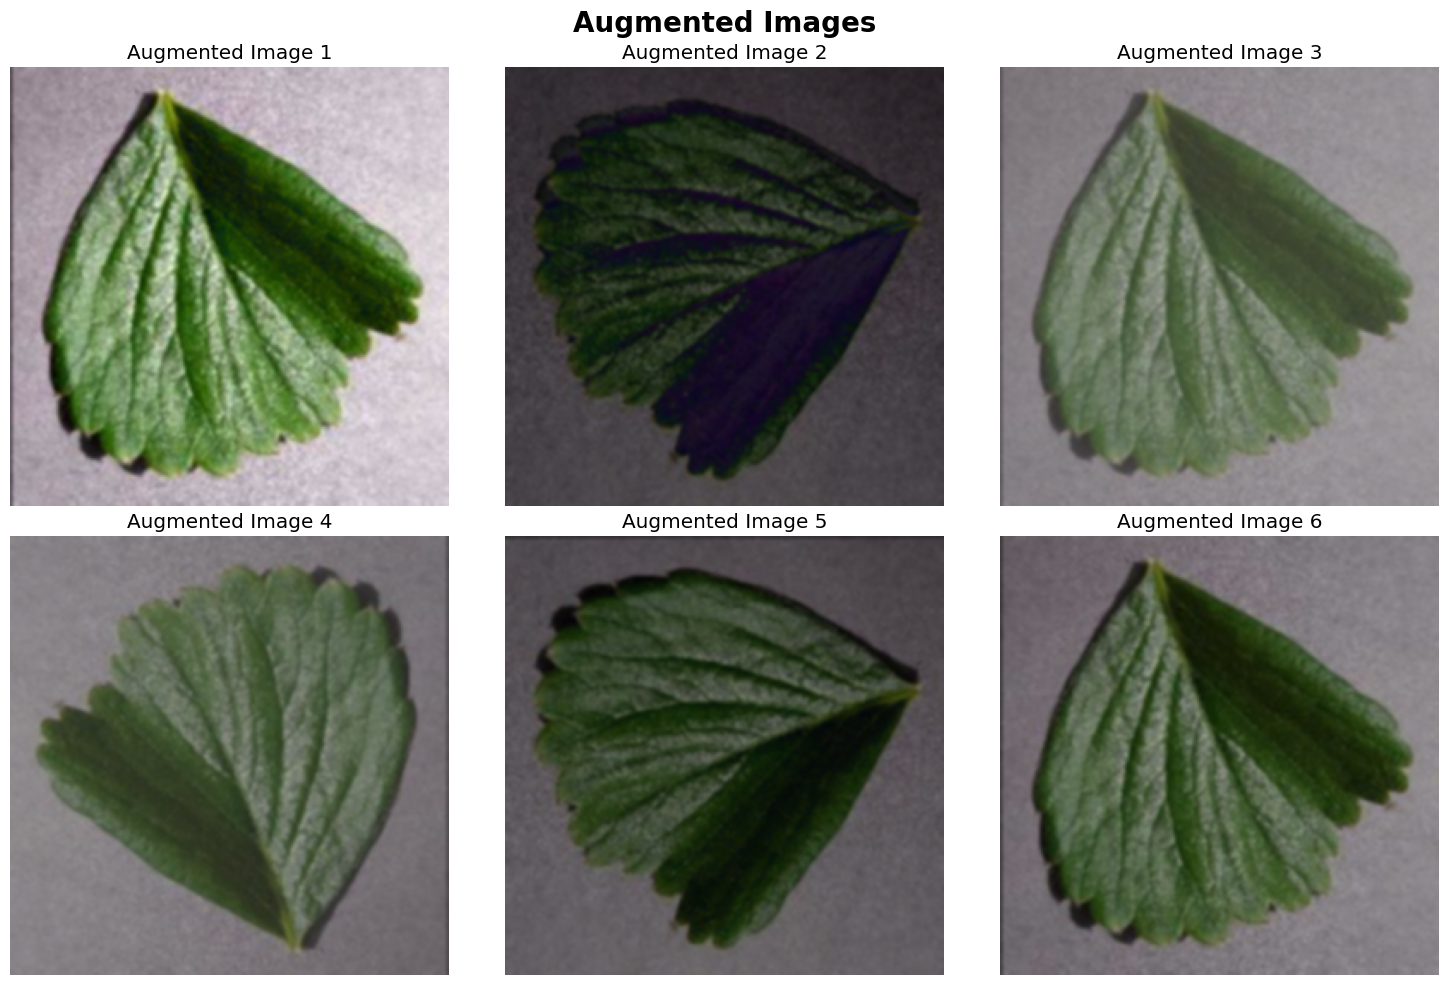

In [26]:
# Define augmentations
def random_rotate(image):
    """Rotate image by a random angle (90, 180, 270 degrees)."""
    angle = random.choice([cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_180, cv2.ROTATE_90_COUNTERCLOCKWISE])
    return cv2.rotate(image, angle)

def horizontal_flip(image):
    """Flip image horizontally."""
    return cv2.flip(image, 1)

def vertical_flip(image):
    """Flip image vertically."""
    return cv2.flip(image, 0)

def random_brightness_contrast(image, alpha_range=(0.5, 1.5), beta_range=(-50, 50)):
    """Adjust brightness and contrast randomly."""
    alpha = random.uniform(*alpha_range)  # Contrast control (0.5–1.5)
    beta = random.randint(*beta_range)  # Brightness control (-50–50)
    return cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

def gaussian_blur(image, kernel_size=(5, 5)):
    """Apply Gaussian blur to the image."""
    return cv2.GaussianBlur(image, kernel_size, 0)

# Combine augmentations
def apply_augmentations(image):
    """Apply a random combination of augmentations."""
    augmentations = [random_rotate, horizontal_flip, vertical_flip, random_brightness_contrast, gaussian_blur]
    random.shuffle(augmentations)  # Shuffle the augmentations for randomness
    for aug in augmentations:
        image = aug(image)
    return image

# Apply augmentations to a sample image
sample_image_path = None
for subdir in os.listdir(train_dir):
    subdir_path = os.path.join(train_dir, subdir)
    if os.path.isdir(subdir_path):
        for file_name in os.listdir(subdir_path):
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                sample_image_path = os.path.join(subdir_path, file_name)
                break
    if sample_image_path:
        break

if not sample_image_path:
    raise ValueError("No valid images found in train_images_dir.")

# Load the sample image
sample_image = cv2.imread(sample_image_path)
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)  # Convert to RGB for display

# Apply augmentations and visualize
plt.figure(figsize=(15, 10))
for i in range(6):
    augmented_image = apply_augmentations(sample_image.copy())
    plt.subplot(2, 3, i + 1)
    plt.imshow(augmented_image)
    plt.axis('off')
    plt.title(f"Augmented Image {i+1}")
plt.suptitle("Augmented Images", fontweight="bold", fontsize=20)
plt.tight_layout()
plt.show()


## Data Preprocessing


### Training Image preprocessing

In [29]:
training_set = tf.keras.utils.image_dataset_from_directory(
    'train',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 70295 files belonging to 38 classes.


### Validation Image Preprocessing

In [30]:
validation_set = tf.keras.utils.image_dataset_from_directory(
    'test',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 17572 files belonging to 38 classes.


## MODELS

### Convolutional Neural Network (CNN)

In [ ]:
# #basic cnn layers
# model = Sequential()
# model.add(Conv2D(32, kernel_size= (3,3), activation = 'relu',input_shape=(128,128,3)))
# model.add(MaxPooling2D(pool_size =(2,2,)))
# model.add(BatchNormalization())
# model.add(Conv2D(64,kernel_size= (3,3), activation = 'relu'))
# model.add(MaxPooling2D(pool_size =(2,2,)))
# model.add(BatchNormalization())
# model.add(Conv2D(64,kernel_size= (3,3), activation = 'relu'))
# model.add(MaxPooling2D(pool_size =(2,2,)))
# model.add(BatchNormalization())
# model.add(Conv2D(96,kernel_size= (3,3), activation = 'relu'))
# model.add(MaxPooling2D(pool_size =(2,2,)))
# model.add(BatchNormalization())
# model.add(Conv2D(32,kernel_size= (3,3), activation = 'relu'))
# model.add(MaxPooling2D(pool_size =(2,2,)))
# model.add(BatchNormalization())

# model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(128, activation = 'relu'))
# model.add(Dropout(0.4))
# model.add(Dense(38, activation = 'softmax'))


#### To avoid Overshooting Loss function
1. Choose small learning rate default 0.001 here we have taken 0.0001
2. There may be chance of underfitting so increase number of neuron
3. Add more Convolutional Layer to extract more feature from images there may be possibilty that model unable to capture relevant feature or model is confusing due to lack of feature so feed with more feature

In [43]:
cnn = tf.keras.models.Sequential()

cnn.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3,padding='same',activation='relu',input_shape=[128,128,3]))
cnn.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

cnn.add(tf.keras.layers.Conv2D(filters=64,kernel_size=3,padding='same',activation='relu'))
cnn.add(tf.keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

cnn.add(tf.keras.layers.Conv2D(filters=128,kernel_size=3,padding='same',activation='relu'))
cnn.add(tf.keras.layers.Conv2D(filters=128,kernel_size=3,activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

cnn.add(tf.keras.layers.Conv2D(filters=256,kernel_size=3,padding='same',activation='relu'))
cnn.add(tf.keras.layers.Conv2D(filters=256,kernel_size=3,activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

cnn.add(tf.keras.layers.Conv2D(filters=512,kernel_size=3,padding='same',activation='relu'))
cnn.add(tf.keras.layers.Conv2D(filters=512,kernel_size=3,activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

cnn.add(tf.keras.layers.Dropout(0.25))

cnn.add(tf.keras.layers.Flatten())

cnn.add(tf.keras.layers.Dense(units=1500,activation='relu'))

cnn.add(tf.keras.layers.Dropout(0.4)) #To avoid overfitting

#Output Layer
cnn.add(tf.keras.layers.Dense(units=38,activation='softmax'))

### Compiling and Training Phase

In [ ]:
# compiling our model 
# cnn.compile(optimizer=tf.keras.optimizers.legacy.Adam(
#     learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


### Model Summary

In [47]:
cnn.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 126, 126, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 63, 63, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 61, 61, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 30, 30, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1500)           │     3,073,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1500)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 38)             │        57,038 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,842,762 (29.92 MB)

 Trainable params: 7,842,762 (29.92 MB)

 Non-trainable params: 0 (0.00 B)

### MODEL Trainining

In [48]:
# labels=(training_set.class_indices)
# labels2=(validation_set.class_indices)
# #fitting data into our model
# fitted_model = model.fit(validation_set,
#                     steps_per_epoch=375,
#                     epochs=10,
#                     validation_data = test_set,
#                     validation_steps = 125)


training_history = cnn.fit(x=training_set,validation_data=validation_set,epochs=10)


Epoch 1/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1192s 542ms/step - accuracy: 0.4085 - loss: 2.0997 - val_accuracy: 0.8317 - val_loss: 0.5290
Epoch 2/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1494s 680ms/step - accuracy: 0.8308 - loss: 0.5391 - val_accuracy: 0.8938 - val_loss: 0.3229
Epoch 3/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1041s 474ms/step - accuracy: 0.9037 - loss: 0.3001 - val_accuracy: 0.9294 - val_loss: 0.2242
Epoch 4/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1351s 615ms/step - accuracy: 0.9319 - loss: 0.2114 - val_accuracy: 0.9432 - val_loss: 0.1760
Epoch 5/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1103s 502ms/step - accuracy: 0.9514 - loss: 0.1463 - val_accuracy: 0.9602 - val_loss: 0.1251
Epoch 6/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1057s 481ms/step - accuracy: 0.9609 - loss: 0.1167 - val_accuracy: 0.9569 - val_loss: 0.1382
Epoch 7/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1067s 486ms/step - accuracy: 0.9689 - loss: 0.0958 - val_accuracy: 0.9562 - val_loss: 0.1400
Epoch 8/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1086s 494ms/s

## Evaluating Model

In [49]:
#Training set Accuracy
train_loss, train_acc = cnn.evaluate(training_set)
print('Training accuracy:', train_acc)

2197/2197 ━━━━━━━━━━━━━━━━━━━━ 285s 130ms/step - accuracy: 0.9918 - loss: 0.0237
Training accuracy: 0.9929298162460327


In [50]:
#Validation set Accuracy
val_loss, val_acc = cnn.evaluate(validation_set)
print('Validation accuracy:', val_acc)

550/550 ━━━━━━━━━━━━━━━━━━━━ 69s 125ms/step - accuracy: 0.9692 - loss: 0.1000
Validation accuracy: 0.9681880474090576


### Saving Model

In [51]:
cnn.save('trained_plant_disease_model.keras')

training_history.history #Return Dictionary of history

{'accuracy': [0.6045380234718323,
  0.8573155999183655,
  0.9139626026153564,
  0.938430905342102,
  0.9541788101196289,
  0.9629561305046082,
  0.9707802534103394,
  0.9751476049423218,
  0.979244589805603,
  0.9820470809936523],
 'loss': [1.343634843826294,
  0.4512193202972412,
  0.26825836300849915,
  0.18942739069461823,
  0.13811039924621582,
  0.1122017353773117,
  0.09028363972902298,
  0.07629357278347015,
  0.0636296346783638,
  0.05578169971704483],
 'val_accuracy': [0.8316640257835388,
  0.8937514424324036,
  0.9293763041496277,
  0.9432051181793213,
  0.9601638913154602,
  0.9569200873374939,
  0.9561802744865417,
  0.9698953032493591,
  0.9576029777526855,
  0.9681880474090576],
 'val_loss': [0.5289519429206848,
  0.32291439175605774,
  0.22424283623695374,
  0.17604589462280273,
  0.12508270144462585,
  0.13818304240703583,
  0.13998228311538696,
  0.09711296856403351,
  0.14078117907047272,
  0.10468096286058426]}

In [52]:
#Recording History in json
import json
with open('training_hist.json','w') as f:
  json.dump(training_history.history,f)

## Some other metrics for model evaluation

In [55]:
test_set = tf.keras.utils.image_dataset_from_directory(
    'test',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=1,
    image_size=(128, 128),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 17572 files belonging to 38 classes.


## Accuracy Visualization

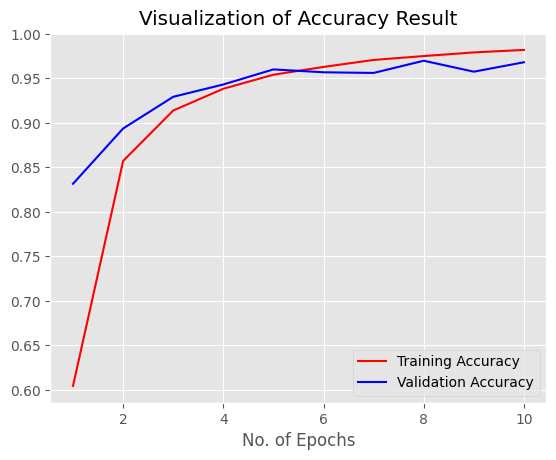

In [53]:
epochs = [i for i in range(1,11)]
plt.plot(epochs,training_history.history['accuracy'],color='red',label='Training Accuracy')
plt.plot(epochs,training_history.history['val_accuracy'],color='blue',label='Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.title('Visualization of Accuracy Result')
plt.legend()
plt.show()

In [56]:
y_pred = cnn.predict(test_set)
predicted_categories = tf.argmax(y_pred, axis=1)

17572/17572 ━━━━━━━━━━━━━━━━━━━━ 196s 11ms/step


In [57]:
true_categories = tf.concat([y for x, y in test_set], axis=0)
Y_true = tf.argmax(true_categories, axis=1)
Y_true

2024-12-09 21:13:29.881675: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<tf.Tensor: shape=(17572,), dtype=int64, numpy=array([ 0,  0,  0, ..., 37, 37, 37])>

In [58]:
predicted_categories

<tf.Tensor: shape=(17572,), dtype=int64, numpy=array([ 0,  0,  0, ..., 37, 37, 37])>

### Confusion Matrix Visualization

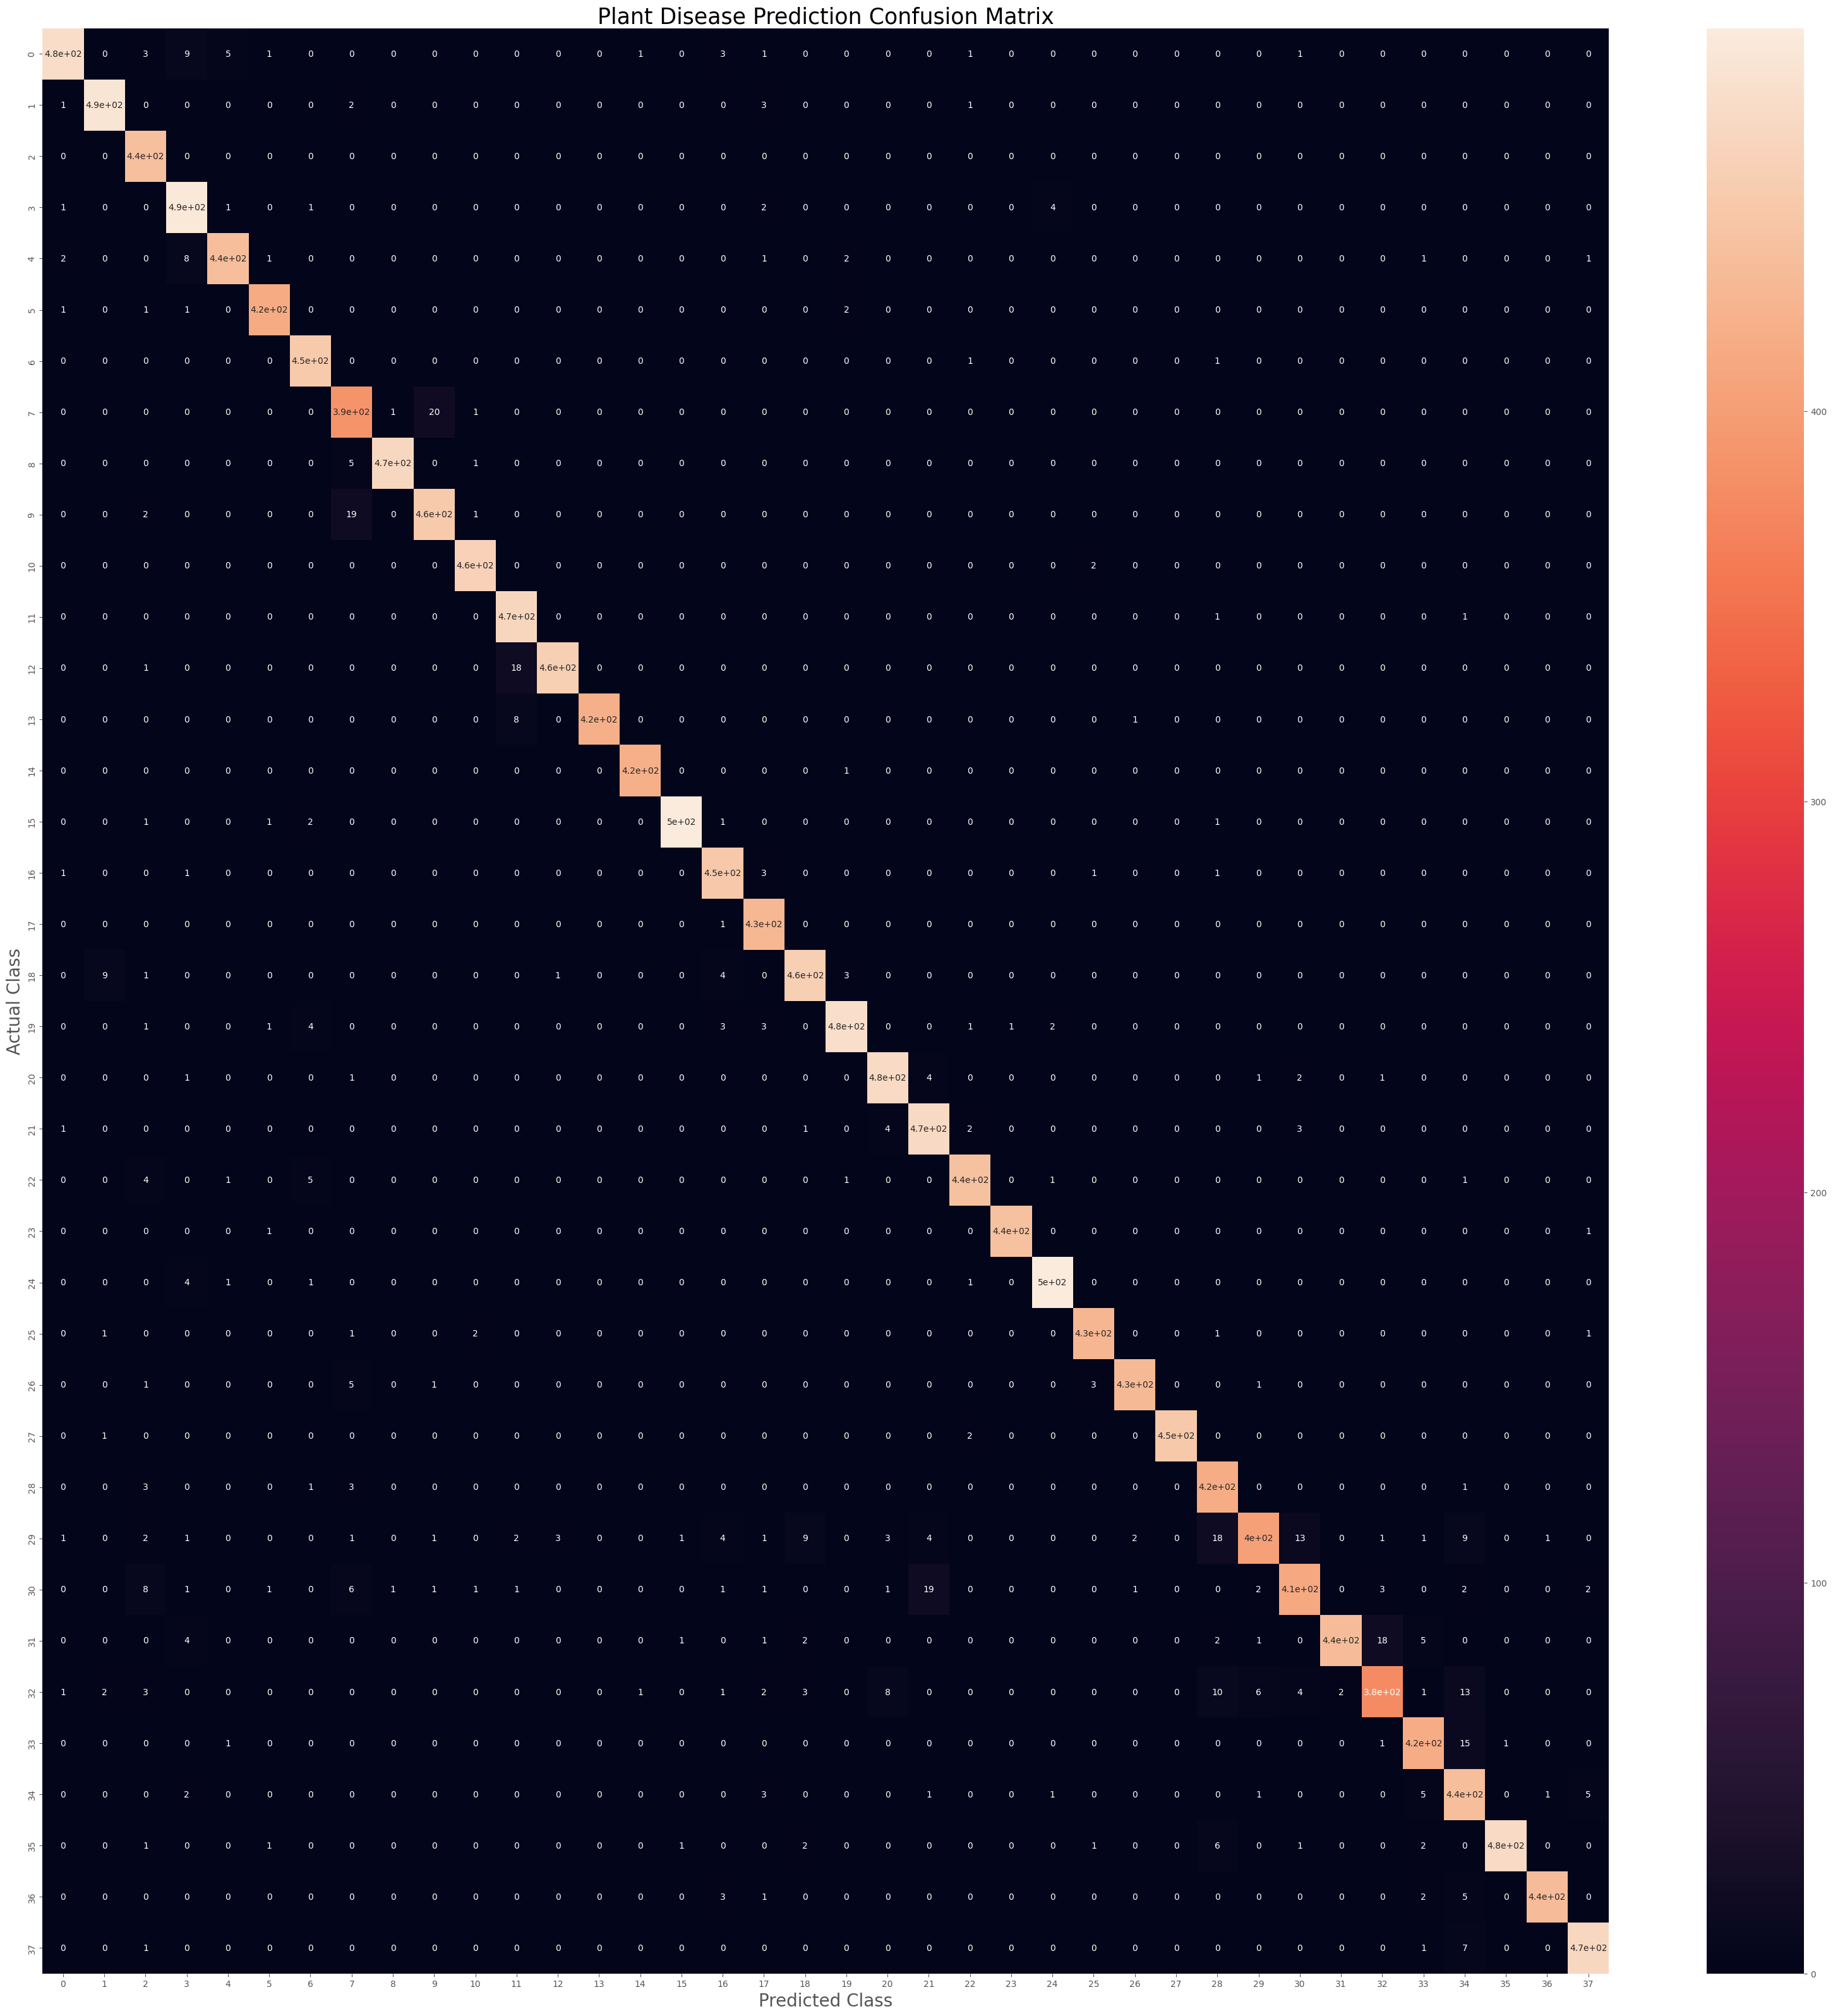

In [61]:
cm = confusion_matrix(Y_true,predicted_categories)

plt.figure(figsize=(40, 40))
sns.heatmap(cm,annot=True,annot_kws={"size": 10})

plt.xlabel('Predicted Class',fontsize = 20)
plt.ylabel('Actual Class',fontsize = 20)
plt.title('Plant Disease Prediction Confusion Matrix',fontsize = 25)
plt.show()

### Precision Recall Fscore

In [62]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(Y_true,predicted_categories)

In [64]:
# Precision Recall Fscore
class_name = validation_set.class_names
print(classification_report(Y_true,predicted_categories,target_names=class_name))

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.98      0.95      0.97       504
                                 Apple___Black_rot       0.97      0.99      0.98       497
                          Apple___Cedar_apple_rust       0.93      1.00      0.96       440
                                   Apple___healthy       0.94      0.98      0.96       502
                               Blueberry___healthy       0.98      0.96      0.97       454
          Cherry_(including_sour)___Powdery_mildew       0.98      0.99      0.99       421
                 Cherry_(including_sour)___healthy       0.97      1.00      0.98       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.90      0.95      0.92       410
                       Corn_(maize)___Common_rust_       1.00      0.99      0.99       477
               Corn_(maize)___Northern_Leaf_Blight       0.95      0.95      0.

# Validating Model Prediction

## Loading Trained Model

In [65]:
cnn = tf.keras.models.load_model('trained_plant_disease_model.keras')

## Visualising and Performing Prediction on Single image

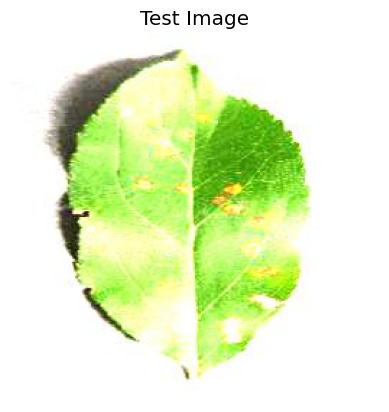

In [67]:
#Test Image Visualization
import cv2
image_path = '/Users/muriss/ads599-module7/images_for_test/AppleCedarRust1.JPG'
# Reading an image in default mode
img = cv2.imread(image_path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) #Converting BGR to RGB
# Displaying the image 
plt.imshow(img)
plt.title('Test Image')
plt.xticks([])
plt.yticks([])
plt.show()

## Testing Model

In [68]:
image = tf.keras.preprocessing.image.load_img(image_path,target_size=(128,128))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = cnn.predict(input_arr)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


In [69]:
print(predictions)

[[5.4133821e-21 2.4542359e-23 1.0000000e+00 1.2590492e-25 9.1035177e-21
  6.2355739e-19 5.3770633e-26 5.0776676e-21 1.0085538e-24 5.6690783e-24
  1.9360334e-29 4.0380479e-19 2.1582525e-22 4.8150775e-27 6.6767566e-22
  7.3058466e-21 6.0635854e-19 3.3833152e-24 1.0227237e-21 2.1427243e-21
  6.4834290e-26 5.8675800e-25 6.2039374e-22 1.9483296e-24 2.3675495e-28
  2.9841497e-23 1.9700929e-24 1.3773508e-26 3.3305431e-17 1.4839373e-23
  7.8631107e-17 8.8295371e-26 2.4831883e-20 4.5266953e-27 1.0091683e-19
  6.4613899e-23 1.2517037e-24 7.9188956e-23]]


In [70]:
result_index = np.argmax(predictions) #Return index of max element
print(result_index)

2


## Displaying the disease prediction

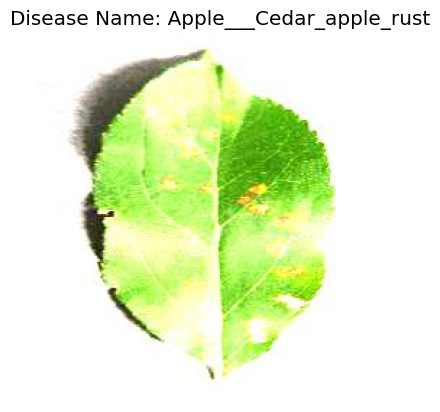

In [71]:
# Displaying the disease prediction
model_prediction = class_name[result_index]
plt.imshow(img)
plt.title(f"Disease Name: {model_prediction}")
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
#Label assignment
label=['Apple___Apple_scab','Apple___Black_rot','Apple___Cedar_apple_rust','Apple___healthy',
       'Blueberry___healthy','Cherry_(including_sour)___healthy','Cherry_(including_sour)___Powdery_mildew',
       'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot','Corn_(maize)___Common_rust_',
       'Corn_(maize)___healthy','Corn_(maize)___Northern_Leaf_Blight','Grape___Black_rot','Grape___Esca_(Black_Measles)',
       'Grape___healthy','Grape___Leaf_blight_(Isariopsis_Leaf_Spot)','Orange___Haunglongbing_(Citrus_greening)','Peach___Bacterial_spot',
       'Peach___healthy','Pepper,_bell___Bacterial_spot','Pepper,_bell___healthy','Potato___Early_blight',
       'Potato___healthy','Potato___Late_blight','Raspberry___healthy','Soybean___healthy',
       'Squash___Powdery_mildew','Strawberry___healthy','Strawberry___Leaf_scorch','Tomato___Bacterial_spot',
       'Tomato___Early_blight','Tomato___healthy','Tomato___Late_blight','Tomato___Leaf_Mold',
       'Tomato___Septoria_leaf_spot','Tomato___Spider_mites Two-spotted_spider_mite','Tomato___Target_Spot',
       'Tomato___Tomato_mosaic_virus','Tomato___Tomato_Yellow_Leaf_Curl_Virus']

## Output Prediction

In [ ]:
# def testing(path):
#     test_image = load_img(path, target_size=(128, 128))
#     test_image = img_to_array(test_image)
#     test_image = np.expand_dims(test_image, axis=0)
#     result = model.predict(test_image)

#     fresult = np.max(result)
#     label2 = label[result.argmax()]
#     print(f"Your leaf disease is --> {label2}")

# #Calling Testing()
# path = '/images_for_test/CornCommonRust2.JPG'
# #path = 'images_for_test/CornCommonRust2.JPG'
# testing(path)


1/1 [==============================] - 0s 15ms/step
Your leaf disease is --> Corn_(maize)___Common_rust_


## ResNet Model

In [76]:

# Load pre-trained ResNet50 model without the top layer to use as a base
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

num_classes = 38
# Freeze the base model
base_model.trainable = False

# Create a new model with ResNet as the base
model_resnet = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')  # Replace 'num_classes' with the actual number of classes
])

# Compile the model
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


In [77]:
# Print model summary to verify the architecture
model_resnet.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,854,886 (91.00 MB)

 Trainable params: 267,174 (1.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [78]:
# Prepare data generators (assuming train_dir and valid_dir are defined)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(rescale=1./255)

# Set up the training and validation data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


### ResNet MODEL Trainining

In [79]:
# Train the model
fitted_model_resnet = model_resnet.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=valid_generator,
    validation_steps=len(valid_generator)
)

Epoch 1/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 692s 313ms/step - accuracy: 0.0704 - loss: 3.4751 - val_accuracy: 0.1839 - val_loss: 3.0183
Epoch 2/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 661s 301ms/step - accuracy: 0.2000 - loss: 2.9462 - val_accuracy: 0.2810 - val_loss: 2.6503
Epoch 3/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 637s 290ms/step - accuracy: 0.2675 - loss: 2.6366 - val_accuracy: 0.3036 - val_loss: 2.4928
Epoch 4/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 654s 298ms/step - accuracy: 0.3041 - loss: 2.4538 - val_accuracy: 0.3244 - val_loss: 2.3686
Epoch 5/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 670s 305ms/step - accuracy: 0.3311 - loss: 2.3377 - val_accuracy: 0.3347 - val_loss: 2.3278
Epoch 6/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 643s 293ms/step - accuracy: 0.3525 - loss: 2.2489 - val_accuracy: 0.3251 - val_loss: 2.3326
Epoch 7/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 637s 290ms/step - accuracy: 0.3661 - loss: 2.1848 - val_accuracy: 0.3534 - val_loss: 2.2517
Epoch 8/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 674s 307ms/step - ac

### Plotting Training and Validation Data For ResNet Model

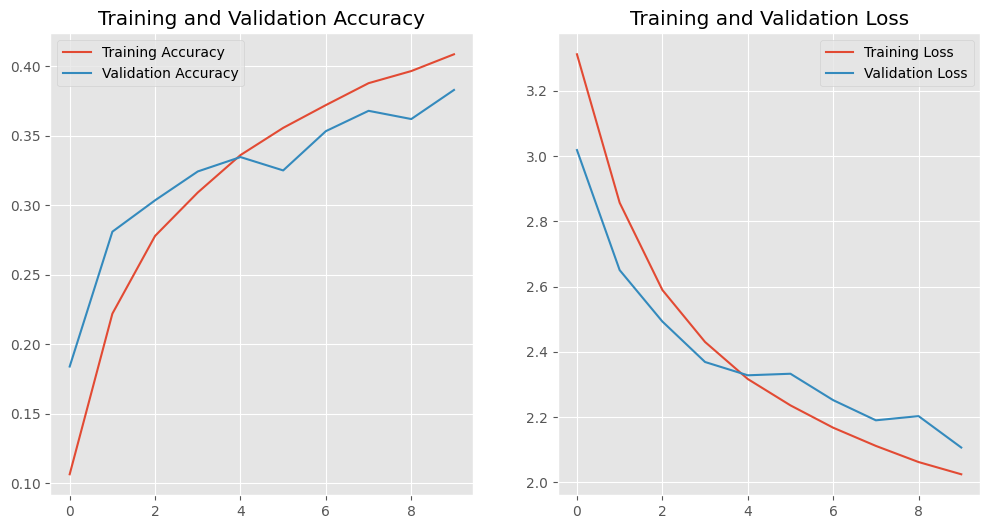

In [80]:
# Plot training and validation accuracy/loss
#import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

plot_training_history(fitted_model_resnet)

## ResNet Model Evaluation

In [81]:
model_resnet.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,389,236 (93.04 MB)

 Trainable params: 267,174 (1.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 534,350 (2.04 MB)

## Observation

The **ResNet model** outperformed the **basic CNN** due to its advanced architecture, which captures complex features necessary for identifying fine-grained leaf disease patterns. 

While the basic CNN serves as a good baseline, ResNet's improved validation performance makes it a more robust choice for deployment in practical applications, especially where accuracy is critical. 